# Práctica 3: Procesamiento del Lenguaje Natural

__Fecha de entrega: 16 de mayo de 2025__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 1234

# 1) Carga del conjunto de datos

Los ficheros `fake.csv` y `true.csv` contienen artícuos de noticias clasificadas como fake (falsas) o true (reales) respectivamente. Cada noticia tiene como atributos:

*   Title: título de la noticia
*   Text: cuerpo del texto de la noticia
*   Subject: tema de la noticia
*   Date: fecha de publicación de la noticia

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar.

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
  Lo primero que hacemos es simplemente cargar los datos, juntarlos, sacar un ejemplo de cada (ua noticia real y una falsa) e imprimir qué "forma" tienen los datos.
</div>

In [17]:
import pandas as pd

# Cargar los datos
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Concatenar ambos DataFrames
# Todavía no los mezclamos
fake_df['label'] = 'fake'
true_df['label'] = 'true'
data = pd.concat([fake_df, true_df], ignore_index=True)

# Mostrar un ejemplo de cada tipo
print("Ejemplo de noticia falsa:")
print(fake_df[['title', 'text', 'subject', 'date']].iloc[0])

print("\nEjemplo de noticia real:")
print(true_df[['title', 'text', 'subject', 'date']].iloc[0])

# Ver los nombres de las columnas
print("Columnas del DataFrame:", data.columns.tolist(), "\n")

# Ver nº de filas, columnas, tipos y no-nulos
data.info()

Ejemplo de noticia falsa:
title       Donald Trump Sends Out Embarrassing New Year’...
text       Donald Trump just couldn t wish all Americans ...
subject                                                 News
date                                       December 31, 2017
Name: 0, dtype: object

Ejemplo de noticia real:
title      As U.S. budget fight looms, Republicans flip t...
text       WASHINGTON (Reuters) - The head of a conservat...
subject                                         politicsNews
date                                      December 31, 2017 
Name: 0, dtype: object
Columnas del DataFrame: ['title', 'text', 'subject', 'date', 'label'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label  

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
    Aquí lo que hacemos es, sacar todas las palabras usando una regex ('\b[a-z]{2,}\b' todas las palabras de 2 o más caracteres que contengan todas las letras de la "a" a la "z", en minúsculas porque ya le hacemos un lowercase), luego contamos su frecuencia y sacamos las 20 más frecuentes.
</div>

In [36]:
from collections import Counter
import re

# Unimos todos los textos en una sola cadena, separándolos con espacios
all_text = " ".join(data['text'].tolist())

# Sacamos todas las palabras en el texto usando una regex
tokens = re.findall(r'\b[a-z]{2,}\b', all_text.lower())

# Counter(tokens) construye un diccionario de la forma {token: número de veces que aparece}
freqs = Counter(tokens)

# most_common(20) devuelve una lista de tuplas de la forma [(palabra, frecuencia), …] ordenada de mayor a menor
most_common = freqs.most_common(20)

print("20 palabras más frecuentes (en el texto sin normalizar):")
for word, count in most_common:
    print(f"{word}: {count}")

20 palabras más frecuentes (en el texto sin normalizar):
the: 1026019
to: 536553
of: 441915
and: 409052
in: 352815
that: 239899
on: 192185
for: 173375
is: 166728
trump: 134000
he: 133367
it: 132970
said: 132825
with: 117923
was: 115803
as: 105098
his: 96369
by: 95852
has: 88563
be: 83698


<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
  Imprimimos en una gráfica los resultados para que sea más visual.<br><br>

  Analizando los resultados podemos ver que la mayoría de palabras son <strong>stopwords</strong>, por lo tanto nos merece la pena normalizar, aunque sea para eliminarlas. <br>
  En la normalización también debemos pasar todo a <strong>lowercase</strong> (como ya hemos hecho para analizar las 20 palabras más frecuentes) para que no haya confusiones por las mayúsculas (queremos que nuestro modelo reconozca Hello como hello y vice versa). <br>
  Por último, para simplificar los textos y que así el modelo se entrene más rápido, con menores costes y menores confusiones, vamos a hacer <strong>stemming</strong> a todos los textos.
</div>

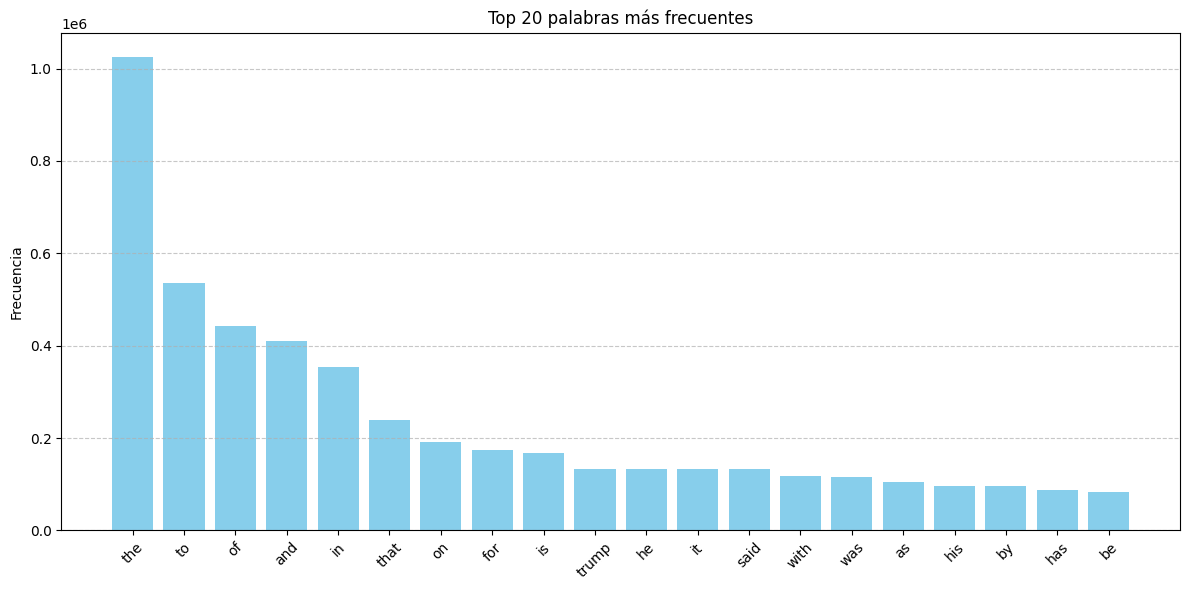

In [31]:
import matplotlib.pyplot as plt

# Separar palabras y cuentas para graficar
words, counts = zip(*most_common)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title('Top 20 palabras más frecuentes')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
  Antes de pasar a normalizar y procesar los datos, dividimos en las 3 partes que se pedían: 60% para training, 20% para validación y el otro 20% para el test final.
</div>

In [35]:
from sklearn.model_selection import train_test_split

# División inicial: 60% entrenamiento, 40% para validación + test
train_df, temp_df = train_test_split(
    data,
    test_size=0.4,
    stratify=data['label'],
    random_state=42
)

# División secundaria: 20% validación, 20% test (de la partición anterior)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

# Mostrar tamaño y distribución de clases
def mostrar_distribucion(df, nombre):
    total = len(df)
    distribucion = df['label'].value_counts(normalize=True)
    print(f"{nombre}: {total} ejemplos")
    print(distribucion, "\n")

mostrar_distribucion(train_df, "Entrenamiento (60%)")
mostrar_distribucion(val_df, "Validación (20%)")
mostrar_distribucion(test_df, "Test (20%)")

Entrenamiento (60%): 26938 ejemplos
label
fake    0.522979
true    0.477021
Name: proportion, dtype: float64 

Validación (20%): 8980 ejemplos
label
fake    0.52294
true    0.47706
Name: proportion, dtype: float64 

Test (20%): 8980 ejemplos
label
fake    0.523051
true    0.476949
Name: proportion, dtype: float64 



# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
  Procedemos a normalizar los datos de la forma descrita anteriormente (<strong>lowercase</strong>, eliminando <strong>stopwords</strong> y con <strong>stemming</strong>) para después analizar qué representación de bolsa de palabras nos conviene más.<br><br>
    <strong>NOTA</strong>: para que vaya la eliminación de stopwords hay que descargarse la primera vez las stopwords de nltk.
</div>

In [37]:
import re
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Descargar (solo la primera vez)
#import nltk
#nltk.download('stopwords')

# Definir stopwords y stemmer en inglés
stop_en   = set(stopwords.words('english'))
stemmer_en = SnowballStemmer('english')

# Pre-compila el regex de tokenización (una o más letras de la "a" a la "z")
token_pattern = re.compile(r'\b[a-z]+\b')

In [40]:
# Función de normalización + stemming
def normalize_and_stem(text: str) -> str:
    # pasar a minúsculas
    text = text.lower()
    # quitar todo lo que no (^) sea letra (a-z) o espacio (|s)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # tokenizar, eliminar stopwords y aplicar stemmer
    tokens = []
    for tok in text.split():
        if tok in stop_en:
            continue
        tokens.append(stemmer_en.stem(tok))
    # reconstruir el texto normalizado
    return " ".join(tokens)

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
    <strong>NOTA</strong>: la siguiente celda tarda varios minutos en ejecutar, ya que tiene que pasar por todas las palabras de todos los textos
</div>

In [43]:
# Aplicar a cada split
for split in (train_df, val_df, test_df):
    split['text_norm'] = split['text'].apply(normalize_and_stem)

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
    Imprimimos un ejemplo de texto antes y después de la normalización.
</div>

In [44]:
# Verificar una muestra
print("Train example — original:", train_df.loc[0, 'text'])
print("Train example — normalized:", train_df.loc[0, 'text_norm'])

Train example — original: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His

<div style="color: #a3c6ff; background-color: #212121; padding: 15px; border-radius: 8px;">
    Una vez ya normalizados, hemos elegido el método TF-IDF (Term Frequency–Inverse Document Frequency) por las ventajas que conlleva: >
</div>

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1) Vectorizador TF–IDF sobre texto ya normalizado (text_norm)
vectorizer = TfidfVectorizer(
    analyzer=str.split,       # tokeniza dividiendo en espacios (ya tenemos stems)
    ngram_range=(1,2),        # unigramas + bigramas
    min_df=5,                 # descarta términos que aparecen en <5 docs de train
    max_df=0.8,               # descarta términos que aparecen en >80% de docs de train
    sublinear_tf=True         # aplica 1 + log(TF) en la parte TF
)

# 2) Ajustar SÓLO con train
X_train = vectorizer.fit_transform(train_df['text_norm'])
X_val   = vectorizer.transform(val_df['text_norm'])
X_test  = vectorizer.transform(test_df['text_norm'])

# 3) Ya tenéis X_train, X_val, X_test listos para entrenar cualquier modelo clásico
print("Dimensiones TF–IDF:", X_train.shape, X_val.shape, X_test.shape)

C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Dimensiones TF–IDF: (26938, 20017) (8980, 20017) (8980, 20017)


In [47]:
# Elige un índice de ejemplo en train
idx = 0
original = train_df.loc[idx, 'text_norm']
vector  = X_train[idx]

print("=== Texto normalizado (antes de BoW) ===")
print(original, "\n")

print("=== Representación TF–IDF (término:valor) ===")
feat_names = vectorizer.get_feature_names_out()
for term_idx, val in zip(vector.indices, vector.data):
    print(f"{feat_names[term_idx]}: {val:.3f}")

=== Texto normalizado (antes de BoW) ===
donald trump wish american happi new year leav instead give shout enemi hater dishonest fake news media former realiti show star one job countri rapid grow stronger smarter want wish friend support enemi hater even dishonest fake news media happi healthi new year presid angri pant tweet great year america countri rapid grow stronger smarter want wish friend support enemi hater even dishonest fake news media happi healthi new year great year america donald j trump realdonaldtrump decemb trump tweet went welll expect kind presid send new year greet like despic petti infantil gibberish trump lack decenc even allow rise gutter long enough wish american citizen happi new year bishop talbert swan talbertswan decemb one like calvin calvinstowel decemb impeach would make great year america also accept regain control congress miranda yaver mirandayav decemb hear talk includ mani peopl hate wonder hate alan sandov alansandov decemb use word hater new year

# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. TF-IDF vectorización
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1,1))
X_train = vectorizer.fit_transform(train_df['text_norm'])
X_val   = vectorizer.transform(val_df['text_norm'])

y_train = train_df['label']
y_val   = val_df['label']

# 2. Definir modelos
models = {
    'Naive Bayes': MultinomialNB(alpha=1.0),
    'SVM': SVC(kernel='linear', C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 3. Entrenar y evaluar en validación
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"Accuracy: {accuracy_score(y_val, preds):.4f}")
    print(classification_report(y_val, preds, target_names=['fake', 'true']))



===== Naive Bayes =====
Accuracy: 0.9318
              precision    recall  f1-score   support

        fake       0.93      0.94      0.94      4696
        true       0.93      0.92      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980


===== SVM =====
Accuracy: 0.9911
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4696
        true       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


===== Random Forest =====
Accuracy: 0.9957
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4696
        true       1.00      0.99      1.00      4284

    accuracy                           1.00      8980
   macro

# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

In [ ]:
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Suponiendo que ya tienes train_df con 'text_norm' y 'label'
sentences = [text.split() for text in train_df['text_norm']]

# Parámetros
MAX_WORDS = 5000
MAX_LEN = 100
EMBEDDING_DIM = 100

In [ ]:
# Entrenar modelo Word2Vec (similar a GloVe en propósito)
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # 1 para Skip-Gram, 0 para CBOW
)

# Guardar modelo para reutilizar
w2v_model.save("word2vec.model")

In [ ]:
from gensim.models import FastText

# Entrenar modelo FastText
fasttext_model = FastText(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # 1 para Skip-Gram, 0 para CBOW
)

# Guardar modelo
fasttext_model.save("fasttext.model")

In [ ]:
# Matriz de embeddings 
def create_embedding_matrix(tokenizer, model, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            try:
                embedding_vector = model.wv[word]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
            except KeyError:
                pass  # Palabra no encontrada en el vocabulario del modelo
    return embedding_matrix

In [ ]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text_norm'])

X_train_seq = tokenizer.texts_to_sequences(train_df['text_norm'])
X_val_seq = tokenizer.texts_to_sequences(val_df['text_norm'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text_norm'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Etiquetas
y_train_keras = train_df['label'].map({'fake': 0, 'true': 1}).values
y_val_keras = val_df['label'].map({'fake': 0, 'true': 1}).values
y_test_keras = test_df['label'].map({'fake': 0, 'true': 1}).values

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Cargar modelo Word2Vec
w2v_model = Word2Vec.load("word2vec.model")
embedding_matrix_w2v = create_embedding_matrix(tokenizer, w2v_model, EMBEDDING_DIM)

# Modelo
model_w2v = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix_w2v],
              trainable=True),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_w2v.summary()

# Entrenar
history_w2v = model_w2v.fit(
    X_train_pad, y_train_keras,
    validation_data=(X_val_pad, y_val_keras),
    epochs=5,
    batch_size=32
)

In [45]:
# Cargar modelo FastText
ft_model = FastText.load("fasttext.model")
embedding_matrix_ft = create_embedding_matrix(tokenizer, ft_model, EMBEDDING_DIM)

# Modelo
model_ft = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix_ft],
              trainable=True),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ft.summary()

# Entrenar
history_ft = model_ft.fit(
    X_train_pad, y_train_keras,
    validation_data=(X_val_pad, y_val_keras),
    epochs=5,
    batch_size=32
)

NameError: name 'FastText' is not defined

# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, name, X_test, y_test):
    preds = (model.predict(X_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} - Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=['fake', 'true']))

evaluate_model(model_w2v, "Word2Vec (GloVe-like)", X_test_pad, y_test_keras)
evaluate_model(model_ft, "FastText", X_test_pad, y_test_keras)